Homework 4

1. Bootstrapping

In [494]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from ISLP import load_data, confusion_table
from sklearn.model_selection import train_test_split 
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree)
from sklearn.ensemble import RandomForestRegressor as RF
from ISLP.models import (summarize)
import random

random.seed(9999)

scores = [65, 70, 68, 73, 75, 80, 85, 78, 90, 100]
scores_series = pd.Series(scores)


n = len(scores)
t = 2.262 #critical value for 95% CI with 9 degrees of freedom
s = scores_series.std()

r = t * (s / (n**(0.5)))

mean = scores_series.mean()

print(mean)
print(f"95% confidence interval: [{mean - r}, {mean + r}]")


78.4
95% confidence interval: [70.68705541054521, 86.1129445894548]


In [495]:

def bootstrap_samples(sample):
    bootstrap_samples = []
    for i in range(40):
        bootstrap = []
        for j in range(len(sample)):
            # pick a random index
            index = random.randint(0, len(sample) - 1)
            # add the random index to the bootstrap sample
            bootstrap.append(sample[index])
        bootstrap_samples.append(bootstrap)
    return bootstrap_samples

bootstraps = bootstrap_samples(scores)
means = []
for sample in bootstraps:
    mean = float(pd.Series(sample).mean())
    # print(sample, "mean:", mean)
    means.append(mean)

means = sorted(means)

means_series = pd.Series(means)

t = 1.96
s = means_series.std()
r = t * s
mean = means_series.mean()

print(f"95% confidence interval for the population mean: [{mean - r}, {mean + r}]")

95% confidence interval for the population mean: [72.02804865303588, 84.21695134696412]


Bootstrapping would be the better method in this case because the original sample is small.

2. Cross-Validation

In [496]:
scores_copy = scores.copy()

sublists = []
for i in range(5):
    sublist = []
    for j in range(2):
        index = random.randint(0, len(scores_copy) - 1)
        item = scores_copy.pop(index)
        sublist.append(item)
    sublists.append(sublist)

print(sublists)

[[90, 100], [68, 73], [85, 78], [65, 75], [80, 70]]


In [497]:
means = []
for sublist in sublists:
    training = []
    for item in scores:
        if item not in sublist:
            training.append(item)
    mean = pd.Series(training).mean()
    means.append(float(mean))
    print(sublist, training, "mean:", mean)

print("means:", means)

[90, 100] [65, 70, 68, 73, 75, 80, 85, 78] mean: 74.25
[68, 73] [65, 70, 75, 80, 85, 78, 90, 100] mean: 80.375
[85, 78] [65, 70, 68, 73, 75, 80, 90, 100] mean: 77.625
[65, 75] [70, 68, 73, 80, 85, 78, 90, 100] mean: 80.5
[80, 70] [65, 68, 73, 75, 85, 78, 90, 100] mean: 79.25
means: [74.25, 80.375, 77.625, 80.5, 79.25]


In [498]:
print("Mean abosolute errors:")
MAEs = []
for i in range(5):
    mean = means[i]
    sublist = sublists[i]
    sum = 0
    for item in sublist:
        sum += abs(item - mean)
    MAE = sum / len(sublist)
    MAEs.append(MAE)
    print(MAE)

Mean abosolute errors:
20.75
9.875
3.875
10.5
5.0


In [499]:
print("Average MAE:", pd.Series(MAEs).mean())

Average MAE: 10.0


In [500]:
mean = scores_series.mean()
sum = 0
for score in scores:
    sum += abs(score - mean)
MAE = sum / len(scores)
print("MAE:", round(MAE, 2))

MAE: 8.28


3. Random Forest and GBM

In [501]:
oj = load_data('OJ')
oj['Store7'] = oj["Store7"].replace({'Yes': 1, 'No': 0}).astype(int)
oj

C:\Users\aidik\AppData\Local\Temp\ipykernel_6528\2412907232.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  oj['Store7'] = oj["Store7"].replace({'Yes': 1, 'No': 0}).astype(int)
C:\Users\aidik\AppData\Local\Temp\ipykernel_6528\2412907232.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  oj['Store7'] = oj["Store7"].replace({'Yes': 1, 'No': 0}).astype(int)


,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.00,0,0,0.500000,1.99,1.75,0.24,0,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.30,0,1,0.600000,1.69,1.75,-0.06,0,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.00,0,0,0.680000,2.09,1.69,0.40,0,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.00,0,0,0.400000,1.69,1.69,0.00,0,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.00,0,0,0.956535,1.69,1.69,0.00,1,0.000000,0.000000,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,CH,252,7,1.86,2.09,0.10,0.00,0,0,0.587822,2.09,1.76,0.33,1,0.000000,0.053763,0.23,0
1066,CH,256,7,1.86,2.18,0.00,0.00,0,0,0.670258,2.18,1.86,0.32,1,0.000000,0.000000,0.32,0
1067,MM,257,7,1.86,2.18,0.00,0.00,0,0,0.736206,2.18,1.86,0.32,1,0.000000,0.000000,0.32,0
1068,CH,261,7,1.86,2.13,0.00,0.24,0,0,0.588965,1.89,1.86,0.03,1,0.112676,0.000000,0.27,0


In [502]:
X = oj[['WeekofPurchase', 'StoreID', 'PriceCH', 'PriceMM', 'DiscCH',
       'DiscMM', 'SpecialCH', 'SpecialMM', 'LoyalCH', 'SalePriceMM',
       'SalePriceCH', 'PriceDiff', 'Store7', 'PctDiscMM', 'PctDiscCH',
       'ListPriceDiff', 'STORE']]
y = oj['Purchase']

In [503]:
# Create train and test split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=314,
                                                    train_size=800,
                                                    shuffle=True) 
Train = pd.merge_ordered(X_train,y_train,left_on=X_train.index,right_on=y_train.index).drop(columns=['key_0'])
Test = pd.merge_ordered(X_test,y_test,left_on=X_test.index,right_on=y_test.index).drop(columns=['key_0'])


In [504]:
# Build a single tree with a max of 6 leaf nodes

tree1 = DTC(max_leaf_nodes=6)
tree1.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,6
,min_impurity_decrease,0.0
,class_weight,None


In [505]:
predictions_train = tree1.predict(X_train)
confusion_table(predictions_train, y_train)

Truth,CH,MM
Predicted,,
CH,445,93
MM,43,219


Training Total Misclassification Error: 136/800, 17%

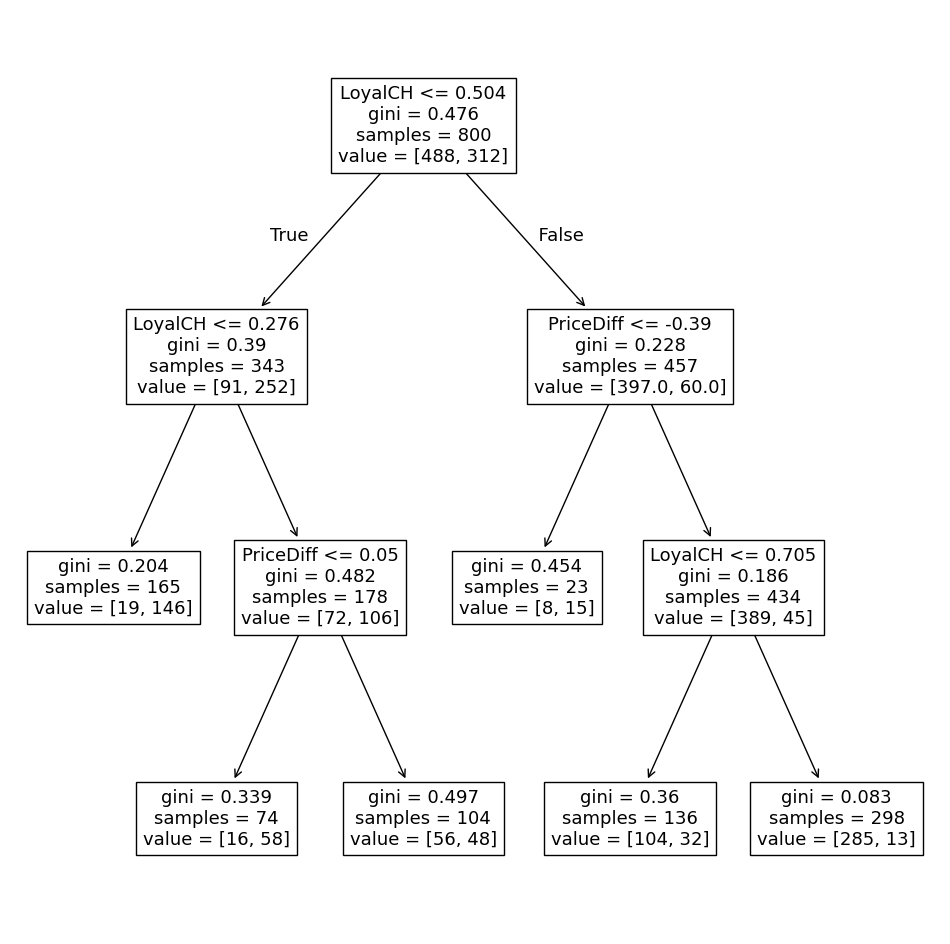

In [506]:
# Construct a graph of the tree

feature_names = list(X_train.columns)
ax = subplots(figsize=(12,12))[1]
plot_tree(tree1,
          feature_names=feature_names,
          ax=ax);

The model determined what brand the customer purchased by using the values for brand loyalty and price difference as predictors. Customers with CH brand loyalty are more likely to buy CH, but when the price difference is 39 cents in favor of MM, only the most loyal, above 0.705, still purchase CH. On the other side of the tree, a price difference of 5 cents in favor of CH is enough for the less CH loyal customers to buy CH.

In [507]:
predictions_test = tree1.predict(X_test)
confusion_table(predictions_test, y_test)

Truth,CH,MM
Predicted,,
CH,147,28
MM,18,77


Test Total Misclassification Error: 46/270, ~17%

In [508]:
# Build a single tree with a max of 8 leaf nodes

tree2 = DTC(max_leaf_nodes=8)
tree2.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,8
,min_impurity_decrease,0.0
,class_weight,None


In [509]:
predictions_test = tree2.predict(X_test)
confusion_table(predictions_test, y_test)

Truth,CH,MM
Predicted,,
CH,139,23
MM,26,82


Test Total Misclassification Error: 49/270, ~18%

The test error increased by about 1%

Although both models have similar performance, second model is overfit because it does not predict new data as well as the first.

In [510]:
y_test = y_test.map({'MM': 0, 'CH': 1}).astype(int)
y_train = y_train.map({'MM': 0, 'CH': 1}).astype(int)

rf_oj = RF(max_features=3,
             n_estimators=1000,
             max_depth=8,
#             min_samples_leaf=2,
#             max_leaf_nodes=None,
             bootstrap=True,
             random_state=314)
rf_oj.fit(X_train, y_train)

,n_estimators,1000
,criterion,'squared_error'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,3
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [511]:
# MSE

y_hat_rf = rf_oj.predict(X_test)
mse_rf = np.mean((y_test - y_hat_rf)**2)
print('test mse: ',mse_rf)

test mse:  0.14417183686345744
